#### https://online.stat.psu.edu/stat501/lesson/13

In [78]:
import os
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
import scipy.stats
filedir = 'STAT501_Lesson13'
os.listdir(filedir)

['ca_learning_new.txt',
 'WLS_W_matrix.png',
 'ca_learning.txt',
 'home_price.txt',
 'galton.txt',
 'quality_measure.txt',
 'market_share.txt']

$$
\hat{\beta}_{OLS} = (X^T X)^{-1} X^T Y
$$

$$
\hat{\beta}_{WLS} = (X^T W X)^{-1} X^T W Y
$$

In [79]:
Image(url=os.path.join(filedir, "WLS_W_matrix.png"), width=600, height=600)

Each weight is inversely proportional to the error variance. Big variance, smaller weight

#### This weight matrix has to be known; it's usually a proportionality constant

In [80]:
df = pd.read_table(os.path.join(filedir, 'galton.txt'))
df

,Parent,Progeny,SD
0,0.21,0.1726,0.01988
1,0.20,0.1707,0.01938
2,0.19,0.1637,0.01896
3,0.18,0.1640,0.02037
4,0.17,0.1613,0.01654
5,0.16,0.1617,0.01594
6,0.15,0.1598,0.01763


In [81]:
y = df['Progeny']
X = df[['Parent']]
X = sm.add_constant(X)

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
OLS_model = sm.OLS(y, X).fit()
WLS_model = sm.WLS(y, X, weights=1/np.power(df['SD'],2)).fit()

In [83]:
OLS_model.params

const     0.127029
Parent    0.210000
dtype: float64

In [84]:
WLS_model.params

const     0.127964
Parent    0.204801
dtype: float64

Results are expected to be similar. In cases where they differ substantially, the procedure can be iterated (usually one or two iterations)

In the example above, SD is given. In designed experiments with large numbers of replicates, weights can be estimated directly from sample variances at each x.

#### The difficulty, in practice, is determining estimates of the error variances.

Do OLS; regress abs(resid) or squared resid against the fitted values or a predictor; use abs(resid) to approximately estimate std, or use squared resid to estimate variance.

Let's walk through an example step by step

In [85]:
df = pd.read_table(os.path.join(filedir, 'ca_learning_new.txt'), encoding='utf-16')
df

,id,num.responses,cost
0,1,16,77
1,2,14,70
2,3,22,85
3,4,10,50
4,5,14,62
5,6,17,70
6,7,10,55
7,8,13,63
8,9,19,88
9,10,12,57


In [90]:
y = df['cost']
X = df[['num.responses']]
X = sm.add_constant(X)

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
b_OLS = np.linalg.inv(X.values.T @ X) @ X.T @ y 

In [92]:
y_hat = X.values @ b_OLS
resids = y - y_hat

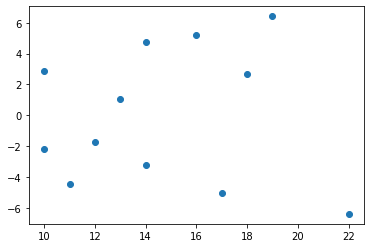

In [94]:
plt.scatter(X['num.responses'], resids)

In [95]:
y2 = np.abs(resids)
X2 = df[['num.responses']]
X2 = sm.add_constant(X2)

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
res_slope = np.linalg.inv(X2.values.T @ X2) @ X2.T @ y2
res_slope

0   -0.904862
1    0.322629
dtype: float64

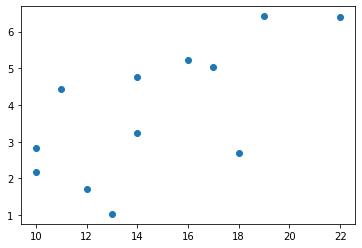

In [46]:
plt.scatter(df['num.responses'], y2)

In [99]:
X2.values @ res_slope

array([4.25720288, 3.61194478, 6.19297719, 2.32142857, 3.61194478,
       4.57983193, 2.32142857, 3.28931573, 5.22509004, 2.96668667,
       4.90246098, 2.64405762])

In [100]:
W = np.diag(1/np.power(X2.values @ slopes2, 2))

In [101]:
b_WLS = np.linalg.inv(X.values.T @ W @ X) @ X.T @ W @ y
b_WLS

0    17.300637
1     3.421106
dtype: float64

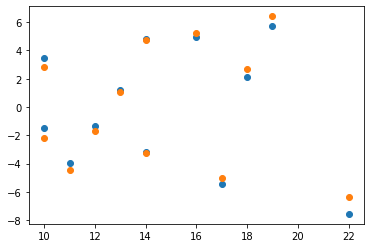

In [103]:
resid_OLS = y - X.values @ b_WLS
resid_WLS = y - X.values @ b_OLS
plt.scatter(df['num.responses'], resid_OLS)
plt.scatter(df['num.responses'], resid_WLS)

In [104]:
def get_leverage(X):
    h_ii = np.diag(X.values @ np.linalg.inv(X.T @ X) @ X.T) 
    return h_ii
h_ii = get_leverage(X)
h_ii

array([0.09453782, 0.08613445, 0.42226891, 0.22058824, 0.08613445,
       0.11764706, 0.22058824, 0.10084034, 0.20168067, 0.12815126,
       0.15336134, 0.16806723])

In [105]:
def get_MSE(y, X, resids):
    n = len(y)
    p = X.shape[1]
    return sum(np.power(resids, 2)) / (n-p)

get_MSE(y, X, resid_OLS)

21.51621484671968

In [66]:
def get_studentized_residuals(resids, MSE, h_ii):
    return resids / np.sqrt(MSE * (1-h_ii))

In [106]:
h_ii = get_leverage(X)
MSE_OLS = get_MSE(y, X, resid_OLS)
MSE_WLS = get_MSE(y, X, resid_WLS)
studentized_residuals_OLS = get_studentized_residuals(resid_OLS, MSE_OLS, h_ii)
studentized_residuals_WLS = get_studentized_residuals(resid_WLS, MSE_WLS, h_ii)

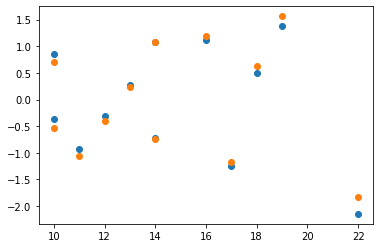

In [107]:
plt.scatter(X['num.responses'], studentized_residuals_OLS)
plt.scatter(X['num.responses'], studentized_residuals_WLS)

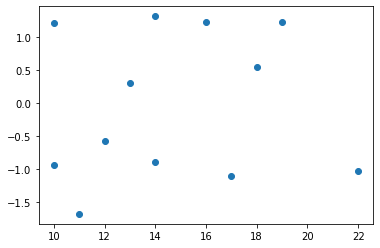

In [110]:
#plt.scatter(X['num.responses'], resid_OLS)
plt.scatter(X['num.responses'], resid_WLS / (X2.values @ slopes2))

With WLS, it is crucial that we use standardized residuals to evaluate it, since it takes into account the changing variance.

#### Robust Regression Methods

Robust regression methods provide an alternative to least squares regression by requiring less restrictive assumptions. These methods attempt to perform better by dampening the influence of outlying cases.

<ol>
    <li>Andrews' Sine</li>
    <li>Huber's Method</li>
    <li>Tukey's Biweight</li>
</ol>
https://www.statsmodels.org/dev/examples/notebooks/generated/robust_models_1.html